# Assignment 4

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple 
from tqdm import tqdm 

## Neural networks

In this problem you will apply the general back propagation method we derived for multiple layer for a 4-layer neural network (input layer > hidden layer 1 > hidden layer 2 > output layer)
$$
\begin{align}
&\mathbf{x} = \text{input} \in \mathbb{R}^{d_0}\\[1em]
&\mathbf{z}^{(1)} = W^{(1)} \mathbf{x} + \mathbf{b}^{(1)} \in \mathbb{R}^{d_1}\\[1em]
&\mathbf{a}^{(2)} = g(\mathbf{z}^{(1)}) \in \mathbb{R}^{d_1} \\[1em]
&\mathbf{z}^{(2)} = W^{(2)} \mathbf{a}^{(2)} + \mathbf{b}^{(2)} \in \mathbb{R}^{d_2}\\[1em]
&\mathbf{y} = h(\mathbf{z}^{(2)})  \in \mathbb{R}^{d_2}\\[1em]
\end{align}
$$

Where $g$ is ReLU and $h$ is identity

## implement Neural network

Define a function such that given weight matrices the function evaluates a specific data point.

In [10]:
def g(v: np.ndarray) -> np.ndarray:
    """Elementwise ReLU activation"""
    return np.maximum(v,0)

def f(x: np.ndarray,listW: List[np.ndarray],listb: List[np.ndarray]) -> np.ndarray:
    """
    Given input x, weights and biases, evaluate neural net

    Input:
    x: input with shape (n,d_0) (d_0 = p)
    listW: a list of weights,  shape of listW[i]: (d_{i+1},d_{i})
    listb: a list of biases,  shape of listd[i]: (d_{i+1},)
    
    Output:
    y: shape (n, d_2) 
    """
    assert len(x.shape) == 2
    a2 = g(listW[0] @ x.T + listb[0][:,None])
    y = (listW[1] @ a2 + listb[1][:,None]).T
    assert y.shape == (x.shape[0],listW[-1].shape[0])
    return y

In [7]:
listd = [10,10,1]
listW = [np.random.randn(listd[j+1],listd[j]) for j in range(2)]
listb = [np.random.randn(listd[j+1]) for j in range(2)]
x = np.random.randn(100,10)

# check shape of input, weights, biases, output
x.shape, [W.shape for W in listW], [b.shape for b in listb], f(x,listW,listb).shape

((100, 10), [(10, 10), (1, 10)], [(10,), (1,)], (100, 1))

## Implement a function that computes gradient

Define another function that computes the gradient, This function only needs to take in a specific value $\mathbf{x} \in \mathbb{R}^{d_0}$.

denote $\mathbf{z}^{(2)}=W^{(1)} \mathbf{x} + \mathbf{b}^{(1)}  \in \mathbb{R}^{d_1}$

Formula of gradient of $\mathbf{y}$ w.r.t each parameter:

$$
\begin{align}
&\frac{\partial \mathbf{y}}{\partial W^{(1)}}=\left[(W^{(2)})^T\circ \sigma'(\mathbf{z}^{(2)})\right]\mathbf{x}^T    \in \mathbb{R}^{d_1 \times d_0} \\[1em]

&\frac{\partial \mathbf{y}}{\partial W^{(2)}}=\mathbf{1} \left ( \mathbf{a}^{(2)} \right )^T= \mathbf{1}\left[\sigma(W^{(1)} \mathbf{x} + \mathbf{b}^{(1)})\right]^T   \in \mathbb{R}^{d_2 \times d_1} \\[1em]

&\frac{\partial \mathbf{y}}{\partial \mathbf{b}^{(1)}}=(W^{(2)})^T\circ \sigma'(\mathbf{z}^{(2)})  \in \mathbb{R}^{d_1} \\[1em]

&\frac{\partial \mathbf{y}}{\partial \mathbf{b}^{(2)}}= \mathbf{1}   \in \mathbb{R}^{d_2}
\end{align}
$$

In [55]:
def givegrad(x,listW,listb):
    """
    Given a specific x and listW and listb, compute the gradient
    
    Input:
    x np.ndarray of shape (d_0,) (d_0=p)  R^p
    listW: list of np.ndarray shape for listW[i] is (d_{i+1},d_{i})
    listb: list of np.ndarray shape for listb[i] is (d_{i+1},)
    
    Output:
    gradW: of same structure as listW
    gradb: of same structure as listb
    """
    gradW = [0*listW[j] for j in range(len(listW))]
    gradb = [0*listb[j] for j in range(len(listb))]

    z2 = listW[0] @ x[:,None]+listb[0][:,None]
    g_prime = z2 > 0
    
    gradW[0]= (listW[1].T * g_prime) @ (x[:,None].T)
    
    gradW[1]= g(z2).T
    
    gradb[0]= (listW[1].T* g_prime).flatten()
    
    gradb[1]=np.ones([listb[1].shape[0]])
    
    return gradW,gradb

Check that the gradient is correct be evaluating the numerical gradient

Recall that for a function $f(x)$ with a gradient and a very small perturbation vector $r$
$$
f(x+r) \approx f(x) + \langle \nabla f(x) , r \rangle
$$
So then
$$
f(x+r) - f(x-r) \approx 2 \langle \nabla f(x) , r \rangle
$$
Note that to check the gradient as above generally much more effective than
$$
f(x+r) - f(x) \approx \langle \nabla f(x) , r \rangle
$$

We could just take $r$ to be a random coordinate vector

In [56]:
x = np.random.randn(listd[0])
gradW,gradb = givegrad(x,listW,listb)
listwperturb = [1e-6*np.random.randn(*listW[j].shape) for j in range(len(listW))]
listbperturb = [1e-6*np.random.randn(*listb[j].shape) for j in range(len(listb))]

# no AssertionError if gradient is correct
for j in range(len(listW)):
    
    listWchanged = listW.copy()
    
    listWchanged[j] = listW[j]+listwperturb[j]
    
    eval1 = f(x[:,None].T,listWchanged,listb)
    
    listWchanged[j] = listW[j]-listwperturb[j]
    
    eval2 = f(x[:,None].T,listWchanged,listb)
    
    assert np.isclose(np.sum(2*gradW[j]*listwperturb[j]),eval1-eval2)

for j in range(len(listb)):
      
   listbchanged = listb.copy()
   
   listbchanged[j] = listb[j]+listbperturb[j]
   
   eval1 = f(x[:,None].T,listW,listbchanged)
   
   listbchanged[j] = listb[j]-listbperturb[j]
   
   eval2 = f(x[:,None].T,listW,listbchanged)
   
   assert np.isclose(np.sum(2*gradb[j]*listbperturb[j]),eval1-eval2)

## Training the neural network

Text(0.5, 1.0, 'Training set')

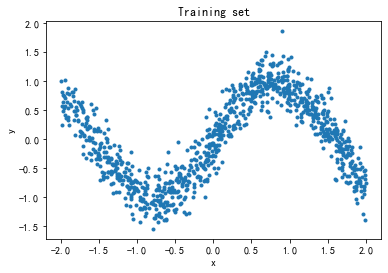

In [22]:
# training set
n=1000
x=4*(np.random.rand(n)-0.5) # (1000,)
y = np.sin(2*x)+0.25*np.random.randn(n) # (1000,) # sine function with random noise
plt.plot(x,y,'.')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training set")

Use stochastic gradient descent to train on this dataset.

In [57]:
def sgd(x: np.ndarray, y: np.ndarray, listWinit: List[np.ndarray], listbinit : List[np.ndarray], 
        step_size: float=0.001, num_iters: int=1000) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    
    """
    Given x and initial weights and bias, using stochastic gradient descent to learn the true weights and bias
    
    Input:
    x: features of training set, shape (n,d_0) (d_0 = p)
    y: label of training set, shape (n, d2)
    listWinit: initial weights, list of np.ndarray shape for listW[i] is (d_{i+1},d_{i})
    listbinit: initial bias, list of np.ndarray shape for listd[i] is (d_{i+1},)
    step_size: learning rate, default to e-3
    num_iters: number of iterations, default to 1000
    
    Output:
    listWlearned: learned weights, of same structure as listWinit
    listblearned: learned bias, of same structure as listbinit
    """
    listWguess = [[0 for i in range(len(listWinit))] for j in range(num_iters)]
    listbguess = [[0 for i in range(len(listbinit))] for j in range(num_iters)]
    listWguess[0],listbguess[0] = listWinit,listbinit

    for i in tqdm(range(1,num_iters)):
    
        # pick a random integer J from [0 , n)
        ksamp = np.random.randint(0, x.shape[0])
    
        gradW,gradb = givegrad(np.array([x[ksamp]]),listWguess[i-1],listbguess[i-1])
        
        # loss = y_hat - y
        loss = float(f(np.array([x[ksamp]])[:,None],listWguess[i-1],listbguess[i-1])) - y[ksamp]
        
        listWguess[i] = [listWguess[i-1][j] - step_size * loss * gradW[j] for j in range(len(listWinit))]

        listbguess[i] = [listbguess[i-1][j] - step_size * loss * gradb[j] for j in range(len(listbinit))]

    return listWguess[-1], listbguess[-1]

## Plot the function
Plot the function that your neural network learned. 

If it looks completely off that's fine as long as your gradient descent code is correct. 

If it looks bad keep playing with the learning rate.

100%|██████████| 99999/99999 [00:04<00:00, 20818.60it/s]


Text(0.5, 1.0, 'Neural network')

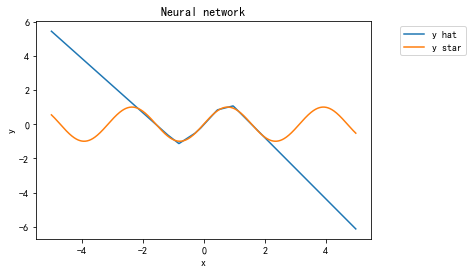

In [58]:
n=1000
x=4*(np.random.rand(n)-0.5) # (1000,)
y = np.sin(2*x)+0.25*np.random.randn(n) # (1000,) # sine function with random noise

# train
# randomly initialize using this paper https://arxiv.org/pdf/1502.01852.pdf
listd = [1,10,1]
listW = [np.random.randn(listd[j+1],listd[j]) for j in range(2)]
listb = [np.random.randn(listd[j+1]) for j in range(2)]
listWinit = [np.sqrt(2)/np.sqrt(listW[j].shape[1])*(np.random.randn(*listW[j].shape)) for j in range(len(listW))]

# intialize bias vectors as zero
listbinit = [0*x for x in listb]
listWlearned, listblearned = sgd(x, y, listWinit, listbinit,step_size=1e-3,num_iters=100000) 

# test
xtest=np.arange(-5,5,0.01) # (1000,)
y_test = np.sin(2*xtest)
yhat = f(xtest[:,None],listWlearned,listblearned)

plt.plot(xtest,yhat,'-',label='y hat')
plt.plot(xtest,y_test,'-',label='y star')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.ylabel("y")
plt.xlabel("x")
plt.title("Neural network")